# Clusterer Options

This tutorial will look at some of the hyperparameters available when performing clustering for Toponymy. We will focus specifically on the ``ToponymyClusterer``, although the ``EVoCClusterer`` works very similarly, albeit with some extra options made available via [EVōC](https://github.com/TutteInstitute/evoc). To get started let's load up some initial libraries and get some data to try clustering with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For our dataset we will use the venerable 20-newsgroups dataset, a classic NLP (Natural Language Processing) dataset of posts to twenty different newsgroups from the 1990s. We will grab a version of the dataset that comes complete with precomputed embedding vectors and a precomputed clusterable representation (that we can visualize to see how the clustering is working). This is a dataset we have used elsewhere in tutorials, so hopefully it is somewhat familiar by now.

In [2]:
newsgroups_df = pd.read_parquet("hf://datasets/lmcinnes/20newsgroups_embedded/data/train-00000-of-00001.parquet")

In [3]:
newsgroups_df.head()

,post,newsgroup,embedding,map
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey,"[-0.04380008950829506, 0.08495834469795227, -0...","[-0.13199903070926666, 10.1972017288208]"
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware,"[0.006855607498437166, -0.05531690642237663, -...","[11.03041934967041, 9.509867668151855]"
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast,"[0.01537406351417303, 0.03572937101125717, -0....","[1.7360589504241943, -0.31686803698539734]"
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware,"[0.010156078264117241, -0.07253803312778473, -...","[10.975887298583984, 10.715202331542969]"
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware,"[-0.008448092266917229, 0.06011670082807541, 0...","[10.498811721801758, 11.010639190673828]"


We only really need the clusterable vectors for this tutorial, so let's extract those.

In [4]:
clusterable_vectors = np.stack(newsgroups_df["map"].values)
document_vectors = np.stack(newsgroups_df["embedding"].values)

Now we need to get to the task of clustering this data, ideally into multiple layers of resolution so that we can have fine-grained topics, which be used to inform the naming of the broader topics. The primary tool for this is the ``ToponymyClusterer`` so we will import that.

In [5]:
from toponymy.clustering import ToponymyClusterer

Let's start by initializing the clusterer using some of the available parameters just as an example. Here we'll look at:

 * ``min_clusters``: the minimum number of clusters in any layer, which means the minimum number of layers in the uppermost layer;
 * ``min_samples``: the minimum number of samples used in density estimates for the density based clustering -- see [HDBSCAN documentation]();
 * ``base_n_clusters``: an estimate for the number of clusters at the base layer (most fine-grained clustering layer);
 * ``next_cluster_size_quantile``: how to determine the resolutuion of the next cluster layer, given the clusters produced for the current layer;
 * ``verbose``: report progress as we go.

In [6]:
clusterer = ToponymyClusterer(
    min_clusters=6,
    min_samples=3,
    base_n_clusters=512,
    next_cluster_size_quantile=0.95,
    verbose=True,
)

As noted in the clusterers tutorial, once we have a clusterer we just need to call fit with both the clusterable vectors and the embedding vectors.

In [7]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
)

Layer 0 found 510 clusters
Layer 1 found 110 clusters
Layer 2 found 21 clusters
Layer 3 found 6 clusters


With the ``verbose`` flag set to ``True`` we get output about the number of clusters found in each layer as the clustering progresses. Note that in the base layer (Layer 0) we only found 510 clusters, and not the 512 we asked for. This is because rather than finding a specific number of clusters the algorithm seeks to find a natural clustering with a resolution that best approximates the desired number of clusters -- it isn't always possible to hit exact numbers, and it is not desireable to force a clustering that would not otherwise occur. The larger the number of clusters sought the better the chance of getting reasonable relative accuracy from some clustering resolution.

Now let's see if we can visualize the clusters. To make this easier, since we will want to do this for our various adjustments to clustering options, let's write  a short function that can flexibly handle this for us.

In [8]:
def plot_cluster_layers(cluster_layers):
    n_rows = int(np.ceil(len(cluster_layers) / 2))
    fig, axs = plt.subplots(n_rows, 2, figsize=(8,8 * n_rows / 2))
    for i, layer in enumerate(cluster_layers):
        max_clusters_ind = layer.cluster_labels.max()
        cluster_shuffle = np.arange(max_clusters_ind + 1)
        np.random.shuffle(cluster_shuffle)
        color_mapping = [plt.cm.Spectral(cluster_shuffle[x] / max_clusters_ind) if x >= 0 else (0.66, 0.66, 0.66, 0.5) for x in layer.cluster_labels]
        axs[i // 2, i % 2].scatter(*clusterable_vectors.T, s=0.1, c=color_mapping, alpha=0.25)
        axs[i // 2, i % 2].set_title(f"Layer {i} clusters")
        axs[i // 2, i % 2].axis('off');
    # clear remaining axes
    for j in range(i + 1, axs.flatten().shape[0]):
        axs[j // 2, j % 2].axis('off');

Now we just pass the ``cluster_layers_`` to the function and let it do the work:

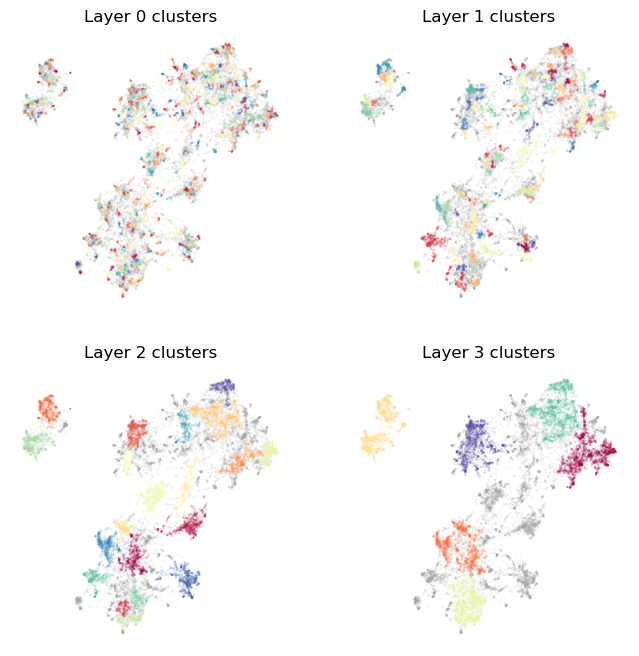

In [9]:
plot_cluster_layers(clusterer.cluster_layers_)

As you can see we get a reasonable clustering that starts off very fine-grained (since we asked for a lot of clusters), but by the top layer picks us just the major groups in the data. Let's try playing with parameters a little to see what effects they have. Suppose we would like even more fine-grained clusters, and the top layer to also differentiate a little more. We can achieve that by increasing ``base_n_clusters`` to get more clusters on the bottom layer, and ``min_clusters`` to stop creating layers once we get down to only 12 clusters.

In [10]:
clusterer = ToponymyClusterer(
    min_clusters=12,
    min_samples=3,
    base_n_clusters=1024,
    next_cluster_size_quantile=0.95,
    verbose=True,
)

In [11]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
)

Layer 0 found 1078 clusters
Layer 1 found 241 clusters
Layer 2 found 49 clusters
Layer 3 found 13 clusters


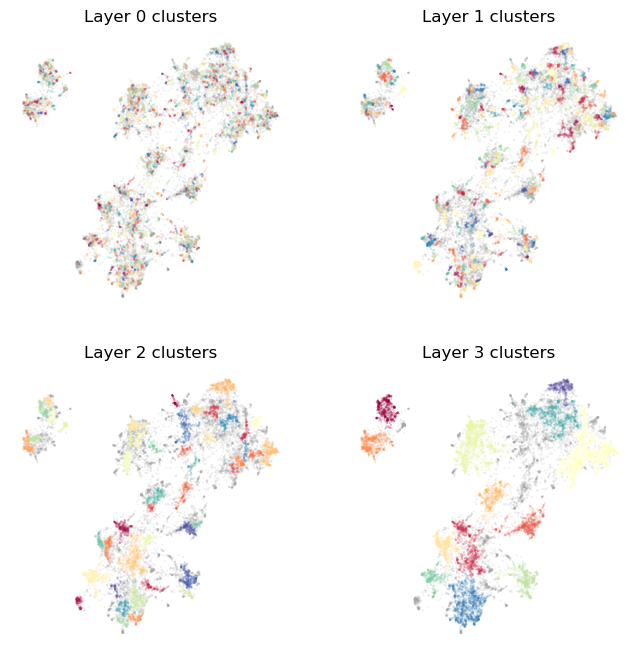

In [12]:
plot_cluster_layers(clusterer.cluster_layers_)

This results in a bottom layer with far more clusters, each of which will be much smaller, and more focussed around very densely specific topcis. We also have a top layer with a wider array of clusters covering more topics. This would ensure the top layer topic names generated by Toponymy will be a little more detailed than the very large scale general topics produced by the first clustering. Note, also, that the intervening layers also have correspondingly more topics.

Suppose, however, instead of more topics in each layer we would rather have more layers produced. This is largely controlled by ``next_cluster_size_quantile``, which determines the *minimum* cluster size for the next layer by taking a quantile of the observed cluster sizes of the current layer. A value of ``1.0`` will ensure that the next layer will have all its clusters at least as large as any in the previous layer. Smaller value will increase the minimum cluster size by less for the next layer. Thus to get more layers we can reduce the ``next_cluster_size_quantile``. Note, of course, that a value of ``0.0`` will result in the layers never progressing. Let's try a value of 0.66, so that the minimum cluster size for the next layer should be larger than two thirds of the clustes in the current layer.

In [13]:
clusterer = ToponymyClusterer(
    min_clusters=6,
    min_samples=3,
    base_n_clusters=512,
    next_cluster_size_quantile=0.66,
    verbose=True,
)

In [14]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
)

Layer 0 found 511 clusters
Layer 1 found 234 clusters
Layer 2 found 107 clusters
Layer 3 found 44 clusters
Layer 4 found 20 clusters
Layer 5 found 10 clusters


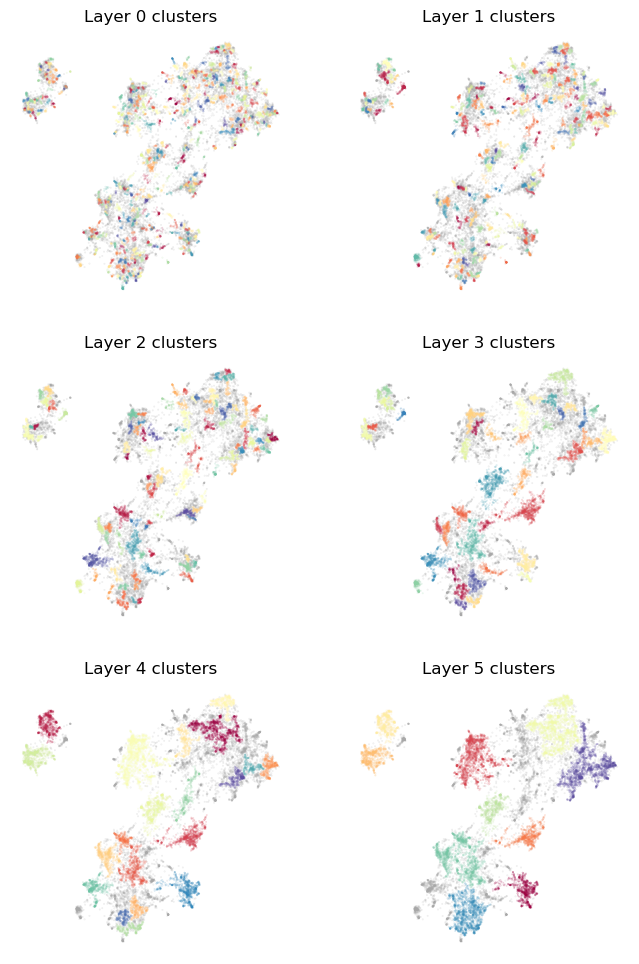

In [15]:
plot_cluster_layers(clusterer.cluster_layers_)

Now we have more layers, as desired. Note that since the minimum cluster size for one layer is quite a bit smaller than the largest cluster in the previous layer we can have some clusters that are identical between layers. Toponymy's topic naming is built to cope with that (without the need for extra LLM calls) so this is not a significant problem.

Now, what if we want to specify the *size* of the clusters in the base layer -- to ensure that we start with small clusters of a given size? We can provide that via the ``base_min_cluster_size``, which specifies the minimum cluster size to use for clusters at the lowest layer. Thus you can either specify the minimum size of clusters at the lowest layer, or the number of clusters at the lowest layer. If you specify neither then ``ToponymyClusterer`` will default to using a ``base_min_cluster_size`` of ``10``, which usually works well, but may be problematic for particularly large datasets. Since we have a small dataset here, let's try a ``base_min_cluster_size`` of ``3``, which should endeavour to pick out very fine grained topics. Since we don't want to call every group of three points that happen to be even somewhat close a cluster we can make the clustering more robust by setting ``min_samples`` which is used to determine when points are densely packed enough to be considered a cluster. The higher the ``min_samples`` value you use, the more conservative the clustering will tend to be -- calling more point background noise rather than clusters. 

In [16]:
clusterer = ToponymyClusterer(
    min_clusters=6,
    min_samples=5,
    base_min_cluster_size=3,
    next_cluster_size_quantile=0.75,
    verbose=True,
)

In [17]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
)

Layer 0 found 932 clusters
Layer 1 found 391 clusters
Layer 2 found 158 clusters
Layer 3 found 56 clusters
Layer 4 found 21 clusters
Layer 5 found 10 clusters


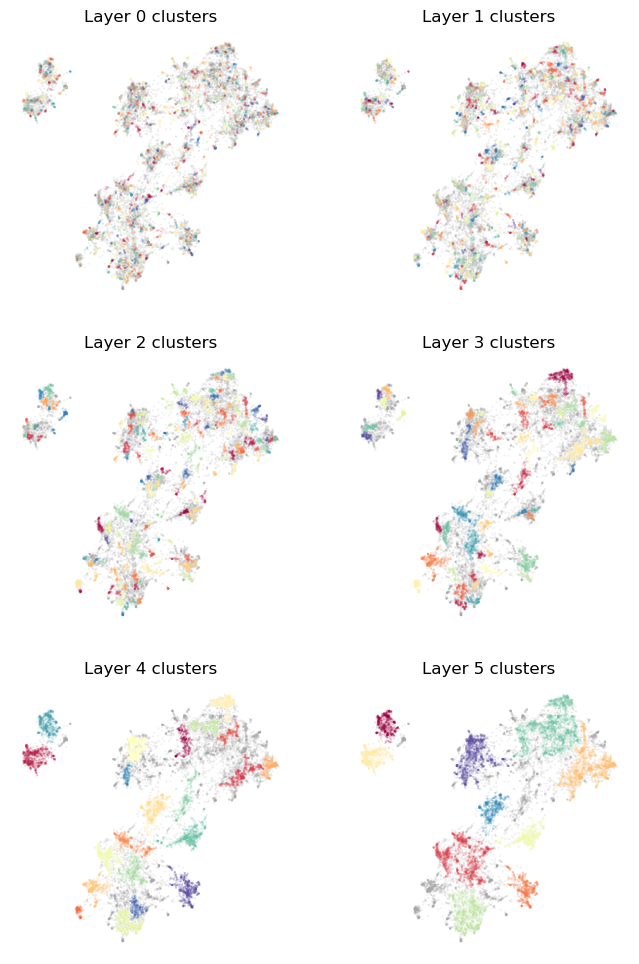

In [18]:
plot_cluster_layers(clusterer.cluster_layers_)

Since we are starting with very small clusters we end up using more layers before we get to the minimum number of clusters (the top layers has 10 clusters, but the next layer would have less than 6). It is worth noting that the top level clusters here are quite imilar to those of the earlier clusterings. The top level is usually fairly robust to parameter choices other than ``min_clusters``.

Hopefully this has been a useful quick introduction to some of the parameters available in the ``ToponymyClusterer`` and how you can use them to extract the kind of topic hierarchy that you want from your data.